Note: this notebook is set up to run with the env.yml containing the name 'polaris_datasets'

## Background
ADME@NCATS is a resource developed by NCATS to host in silico prediction models for various ADME (Absorption, Distribution, Metabolism and Excretion) properties. The resource serves as an important tool for the drug discovery community with potential uses in compound optimization and prioritization. The models were retrospectively validated on a subset of marketed drugs which resulted in very good accuracies.

Data that were used for developing the models are made publicly accessible by depositing them into PubChem database. In some instances, when complete data cannot be made public, a subset of the data are deposited into PubChem. Links to the PubChem assays can be found in the individual model pages. The users are highly encouraged to use these data for development and validation of QSAR models.

## Assay Information
Aqueous solubility is one of the most important properties in drug discovery, as it has profound impact on various drug properties, including biological activity, pharmacokinetics (PK), toxicity, and in vivo efficacy. Both kinetic and thermodynamic solubilities are determined during different stages of drug discovery and development. 

## Description of readout:
- **PUBCHEM_ACTIVITY_OUTCOME**: Corresponds to the phenotype observed. For all compounds with Moderate/High phenotype, PUBCHEM_ACTIVITY_OUTCOME is "active" (class = 1). For all        compounds with Low phenotype, PUBCHEM_ACTIVITY_OUTCOME is "inactive" (class = 0).
- **PUBCHEM_ACTIVITY_SCORE**: Whole number in Solubility (ug/mL) of the compound.
- **PHENOTYPE**: Indicates type of activity observed: 0-10: Low Solubility (class = 0) >10: Moderate/High Solubility (class = 1)
- **KINETIC AQUEOUS SOLUBILITY**: Numerical value of the observed aqueous solubility, measured in ug/mL.

## Data resource

**Reference**: https://pubmed.ncbi.nlm.nih.gov/31176566/ 

**Raw data**: https://pubchem.ncbi.nlm.nih.gov/bioassay/1645848

In [1]:
import datamol as dm

from polaris import (
    curation,
    load_dataset,
)
from polaris.curation.viz_utils import (
    visualize_distribution,
    verify_stereoisomers,
    check_undefined_stereocenters,
)
from polaris.dataset import Dataset, ColumnAnnotation
from polaris.utils.types import HubOwner, License
from polaris.hub.client import PolarisHubClient

import tempfile

import pandas as pd

All datasets were downloaded directly from Pubchem on 2024-03-21 by following the PubChem Bioassay links on https://opendata.ncats.nih.gov/adme/data.

In [2]:
# Load the dataset
aid = 'AID_1645848'
data = pd.read_parquet(f'gs://polaris-public/data/raw/ADME_NCATS/{aid}_raw.parquet')
data

,PUBCHEM_RESULT_TAG,PUBCHEM_SID,PUBCHEM_CID,PUBCHEM_EXT_DATASOURCE_SMILES,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_ACTIVITY_SCORE,PUBCHEM_ACTIVITY_URL,PUBCHEM_ASSAYDATA_COMMENT,Phenotype,Kinetic Aqueous Solubility (ug/mL),Analysis Comment
0,RESULT_TYPE,NaN,NaN,None,None,NaN,NaN,NaN,STRING,STRING,STRING
1,RESULT_DESCR,NaN,NaN,None,None,NaN,NaN,NaN,Indicates type of activity observed: 0-10: Low...,Numerical value of the observed aqueous solubi...,Annotation/notes on a particular compound's da...
2,1,387065710.0,5280445.0,C1=CC(=C(C=C1C2=CC(=O)C3=C(C=C(C=C3O2)O)O)O)O,Active,100.0,NaN,NaN,Moderate/High,>100,class = 0
3,2,174007039.0,72303.0,C=CCC1=CC(=C(C=C1)O)C2=CC(=C(C=C2)O)CC=C,Active,100.0,NaN,NaN,Moderate/High,>100,class = 0
4,3,144206281.0,5388936.0,CC[C@@H]1C(=O)N2CCC[C@H]2C(=O)N([C@H](C(=O)N3C...,Active,100.0,NaN,NaN,Moderate/High,>100,class = 0
...,...,...,...,...,...,...,...,...,...,...,...
2529,2528,375862622.0,75465982.0,C1=CSC(=C1)C2=CC=NC3=NC(=NN23)CC4=CC=C(C=C4)F,Inconclusive,0.0,NaN,NaN,None,None,None
2530,2529,363681098.0,68289010.0,C[C@@H](C1=CN2C=CN=C2C=C1)N3C4=NC(=CN=C4N=N3)C...,Inconclusive,0.0,NaN,NaN,None,None,None
2531,2530,377020474.0,66610682.0,CC(C)CN(CC(=O)N(CCCN1CCCC1=O)CC(=O)N)C(=O)CNCC...,Inconclusive,0.0,NaN,NaN,None,None,None
2532,2531,377020256.0,5319693.0,CC/C=C\CC1C(CCC1=O)CC(=O)OC,Inconclusive,0.0,NaN,NaN,None,None,None


Rows 0 and 1 are metadata; we will keep them separate.

In [3]:
meta_start = 0 # Start row index
meta_end = 2 # End row index + 1
data_meta = data.iloc[meta_start:(meta_end),:].copy() # Save the metadata rows
data = data.drop(labels=list(range(meta_start, meta_end)), axis=0).reset_index(drop=True) # Drop those rows from the main dataframe
data_meta

,PUBCHEM_RESULT_TAG,PUBCHEM_SID,PUBCHEM_CID,PUBCHEM_EXT_DATASOURCE_SMILES,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_ACTIVITY_SCORE,PUBCHEM_ACTIVITY_URL,PUBCHEM_ASSAYDATA_COMMENT,Phenotype,Kinetic Aqueous Solubility (ug/mL),Analysis Comment
0,RESULT_TYPE,NaN,NaN,None,None,NaN,NaN,NaN,STRING,STRING,STRING
1,RESULT_DESCR,NaN,NaN,None,None,NaN,NaN,NaN,Indicates type of activity observed: 0-10: Low...,Numerical value of the observed aqueous solubi...,Annotation/notes on a particular compound's da...


Drop the metadata rows and keep only the smiles, ID and outcome rows

In [4]:
# Keep only the SMILES, ID and outcome rows
columns_to_keep = [ 'PUBCHEM_EXT_DATASOURCE_SMILES', 
                    'PUBCHEM_ACTIVITY_OUTCOME',
                    'PUBCHEM_ACTIVITY_SCORE', 
                    'Phenotype',
                    'Kinetic Aqueous Solubility (ug/mL)']
data = data[columns_to_keep]
data.rename(columns = {'PUBCHEM_EXT_DATASOURCE_SMILES' : 'SMILES'}, inplace = True)
# Rename Kinetic Aqueous Solubility (ug/mL) (we will specify minutes in the metadata)
data.rename(columns={'Kinetic Aqueous Solubility (ug/mL)': 'Kinetic Aqueous Solubility'}, inplace = True)
# Rename all columns to uppercase
for col in data.columns:
    data.rename(columns={col:col.upper()}, inplace=True)
# Drop rows where we don't have a solubility score (the other columns depend on this)
print(data.shape)
data.dropna(inplace = True, ignore_index=True)
print(f'after dropping inconclusive solubility: {data.shape}')

(2532, 5)
after dropping inconclusive solubility: (2456, 5)


We dropped ~80 compounds with inconclusive results.

In [5]:
data

,SMILES,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_ACTIVITY_SCORE,PHENOTYPE,KINETIC AQUEOUS SOLUBILITY
0,C1=CC(=C(C=C1C2=CC(=O)C3=C(C=C(C=C3O2)O)O)O)O,Active,100.0,Moderate/High,>100
1,C=CCC1=CC(=C(C=C1)O)C2=CC(=C(C=C2)O)CC=C,Active,100.0,Moderate/High,>100
2,CC[C@@H]1C(=O)N2CCC[C@H]2C(=O)N([C@H](C(=O)N3C...,Active,100.0,Moderate/High,>100
3,C1=CC(=C(C(=C1)Cl)C2=C3C=CC(=NN3C=NC2=O)SC4=C(...,Active,100.0,Moderate/High,>100
4,C1=CC(=CC=C1NC(=O)CC2=CC(=C(C=C2)Cl)Cl)S(=O)(=...,Active,100.0,Moderate/High,>100
...,...,...,...,...,...
2451,C1=CC=C(C=C1)C2=NC3=CC=CC=C3C(=C2)C(=O)NC4=CC=...,Inactive,0.0,Low,0.098
2452,CN1C(=NN=N1)SC2=NC=NC3=C2C=C(S3)C4=CC=CC=C4,Inactive,0.0,Low,0.088
2453,CC1=CC=C(C=C1)N2C3=NC=NC(=C3C=N2)NC4=CC(=C(C=C...,Inactive,0.0,Low,0.075
2454,CCOC1=CC=C(C=C1)/C=C/C2=NC3=CC=CC=C3N2S(=O)(=O...,Inactive,0.0,Low,0.035


Looking at the kinds of variables in each column:

In [6]:
data[['PUBCHEM_ACTIVITY_OUTCOME', 'PUBCHEM_ACTIVITY_SCORE', 'PHENOTYPE', 'KINETIC AQUEOUS SOLUBILITY']].value_counts()

PUBCHEM_ACTIVITY_OUTCOME  PUBCHEM_ACTIVITY_SCORE  PHENOTYPE      KINETIC AQUEOUS SOLUBILITY
Inactive                  1.0                     Low            <1                            915
Active                    51.0                    Moderate/High  >51                            21
                          58.0                    Moderate/High  >58                            21
                          45.0                    Moderate/High  >45                            20
                          61.0                    Moderate/High  >61                            19
                                                                                              ... 
                          37.0                    Moderate/High  36.88                           1
                                                                 36.89                           1
                                                                 37.15                           1
                 

In [7]:
print(f'number of ">" assignments in kinetic aqueous solubility: {len([i for i in data['KINETIC AQUEOUS SOLUBILITY'].unique() if '>' in str(i)])}')
print(f'unique values in phenotype: {data['PHENOTYPE'].unique()}')

number of ">" assignments in kinetic aqueous solubility: 74
unique values in phenotype: ['Moderate/High' 'Low']


There are a lot of different kinds of values in the aqueous solubility column. We'll try to harmonize them. Since the measurements go up to 100, 101.0 will correspond to '>100' and 0.0 will correspond to '<1'.

In [8]:
# Map active/inactive and stable/unstable to 1 and 0
data['PUBCHEM_ACTIVITY_OUTCOME'] = data['PUBCHEM_ACTIVITY_OUTCOME'].map({'Active':1.0, 'Inactive':0.0})
data['PHENOTYPE'] = data['PHENOTYPE'].map({'Moderate/High':1.0, 'Low':0.0})

# Convert kinetic aqueous solubility to digits
kas_values = []
for i in data['KINETIC AQUEOUS SOLUBILITY']:
    if '>' in i:
        kas_values.append(101.0)
    elif '<' in i:
        kas_values.append(0.0)
    else:
        kas_values.append(float(i))
data['KINETIC AQUEOUS SOLUBILITY'] = kas_values

In [9]:
data.isna().any()

SMILES                        False
PUBCHEM_ACTIVITY_OUTCOME      False
PUBCHEM_ACTIVITY_SCORE        False
PHENOTYPE                     False
KINETIC AQUEOUS SOLUBILITY    False
dtype: bool

In [10]:
# Define data column names
endpoints = [
    'PUBCHEM_ACTIVITY_OUTCOME',
    'PUBCHEM_ACTIVITY_SCORE',
    'PHENOTYPE',
    'KINETIC AQUEOUS SOLUBILITY',
]
data_cols = endpoints
mol_col = 'SMILES'

### Run preliminary curation for data inspection

In [11]:
# preliminary curation for data inspection
curator = curation.MolecularCurator(
    data=data,
    data_cols=data_cols,
    mol_col=mol_col,
    mask_stereo_undefined_mols=False,
    keep_all_rows = True
)
data_look = curator()

2024-03-28 16:12:15.230 | WARNING  | polaris.curation._data_curator:check_outliers:188 - Detected 17 outliers for data column PUBCHEM_ACTIVITY_SCORE using zscore. Please revise the data and consider remove the outliers. 
/Users/shawn.whitfield/Documents/ValenceLabs/Polaris/polaris/polaris/curation/utils.py:183: RuntimeWarning: divide by zero encountered in divide
  mod_zscore = deviation_from_med / (consistency_correction * mad)
/Users/shawn.whitfield/Documents/ValenceLabs/Polaris/polaris/polaris/curation/utils.py:183: RuntimeWarning: invalid value encountered in divide
  mod_zscore = deviation_from_med / (consistency_correction * mad)
/Users/shawn.whitfield/Documents/ValenceLabs/Polaris/polaris/polaris/curation/_data_curator.py:77: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.loc[data[NO_STEREO_UNIQUE_ID].isin(mo

In [12]:
data_look.head()

,SMILES,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_ACTIVITY_SCORE,PHENOTYPE,KINETIC AQUEOUS SOLUBILITY,ORIGINAL_PUBCHEM_ACTIVITY_OUTCOME,ORIGINAL_PUBCHEM_ACTIVITY_SCORE,ORIGINAL_PHENOTYPE,ORIGINAL_KINETIC AQUEOUS SOLUBILITY,ORIGINAL_SMILES,...,OUTLIER_PHENOTYPE,OUTLIER_KINETIC AQUEOUS SOLUBILITY,PUBCHEM_ACTIVITY_OUTCOME_zscore,PUBCHEM_ACTIVITY_OUTCOME_stereo_cliff,PUBCHEM_ACTIVITY_SCORE_zscore,PUBCHEM_ACTIVITY_SCORE_stereo_cliff,PHENOTYPE_zscore,PHENOTYPE_stereo_cliff,KINETIC AQUEOUS SOLUBILITY_zscore,KINETIC AQUEOUS SOLUBILITY_stereo_cliff
0,COC1=CC2=C(C=CN=C2C=C1OC)OC3=CC=C(C=C3)NC(=O)C...,0.0,1.0,0.0,0.00,0.0,1.0,0.0,0.00,COC1=CC2=C(C=CN=C2C=C1OC)OC3=CC=C(C=C3)NC(=O)C...,...,False,False,NaN,NaN,-0.674491,NaN,NaN,NaN,-0.674491,NaN
1,C1CN(CCC1C(=O)N)C2=NC(=CS2)C3=CC(=CC=C3)Br,1.0,20.0,1.0,20.47,1.0,20.0,1.0,20.47,C1CN(CCC1C(=O)N)C2=NC(=CS2)C3=CC(=CC=C3)Br,...,False,False,inf,NaN,3.597284,NaN,inf,NaN,2.476314,NaN
2,CC1=CC=CC=C1NC(=O)NC2=CC=CS2,1.0,34.0,1.0,101.00,1.0,34.0,1.0,101.00,CC1=CC=CC=C1NC(=O)NC2=CC=CS2,...,False,False,inf,NaN,6.744908,NaN,inf,NaN,14.871736,NaN
3,C[C@H](/C=C(\C)/C=C/C(=O)NO)C(=O)C1=CC=C(C=C1)...,1.0,45.0,1.0,101.00,1.0,45.0,1.0,101.00,C[C@H](/C=C(\C)/C=C/C(=O)NO)C(=O)C1=CC=C(C=C1)...,...,False,False,inf,NaN,9.218040,NaN,inf,NaN,14.871736,NaN
4,CCN(CC)C(=O)C1=C(C2=C(S1)N(C(=O)N(C2=O)CC3=CC=...,0.0,1.0,0.0,0.00,0.0,1.0,0.0,0.00,CCN(CC)C(=O)C1=C(C2=C(S1)N(C(=O)N(C2=O)CC3=CC=...,...,False,False,NaN,NaN,-0.674491,NaN,NaN,NaN,-0.674491,NaN


The curator has detected outliers. Let's have a look at them.

[<Figure size 1600x400 with 2 Axes>,
 <Figure size 1600x400 with 2 Axes>,
 <Figure size 1600x400 with 2 Axes>,
 <Figure size 1600x400 with 2 Axes>]

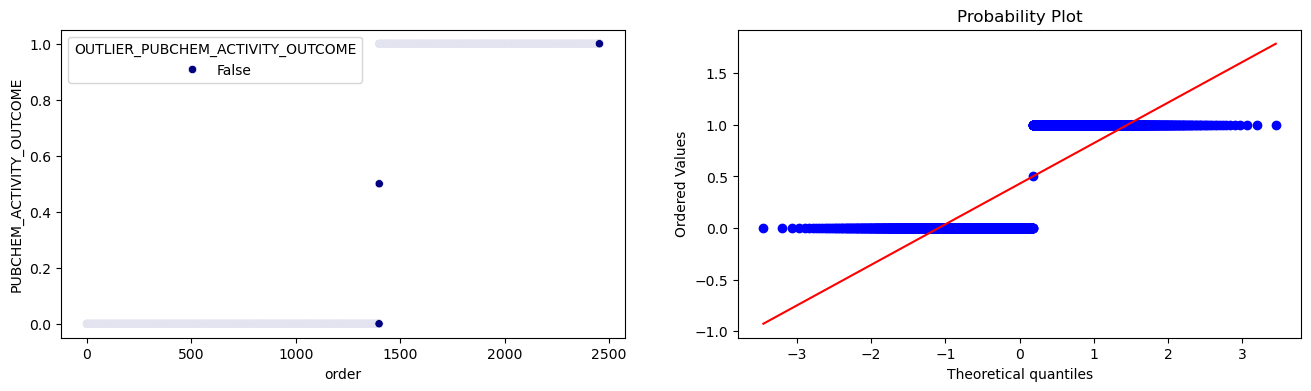

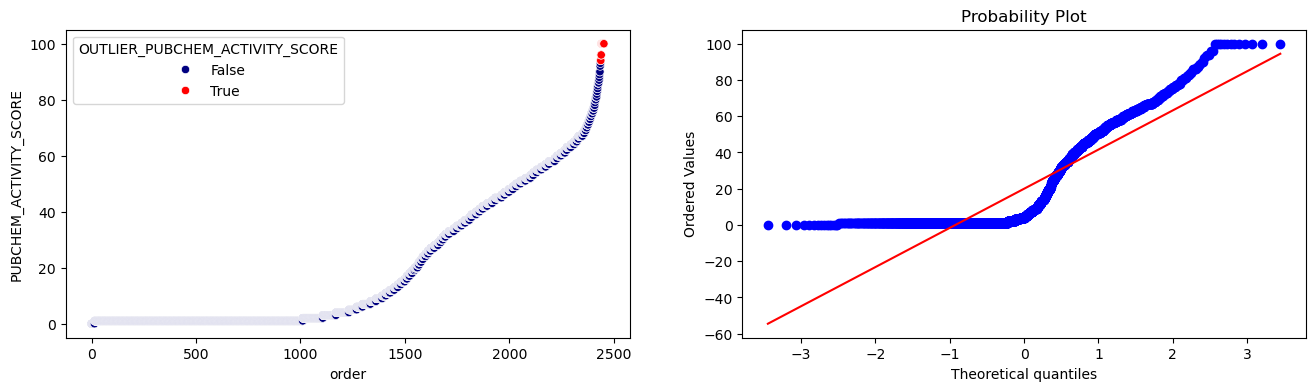

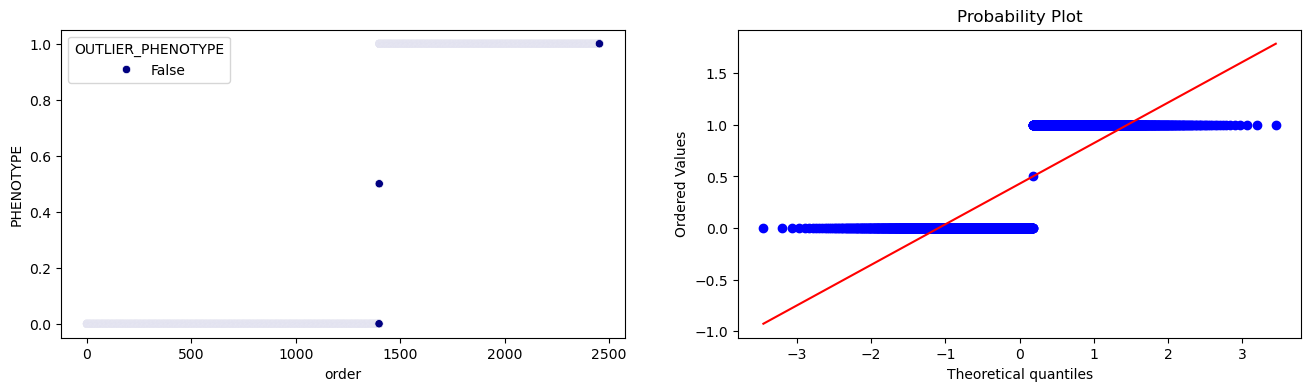

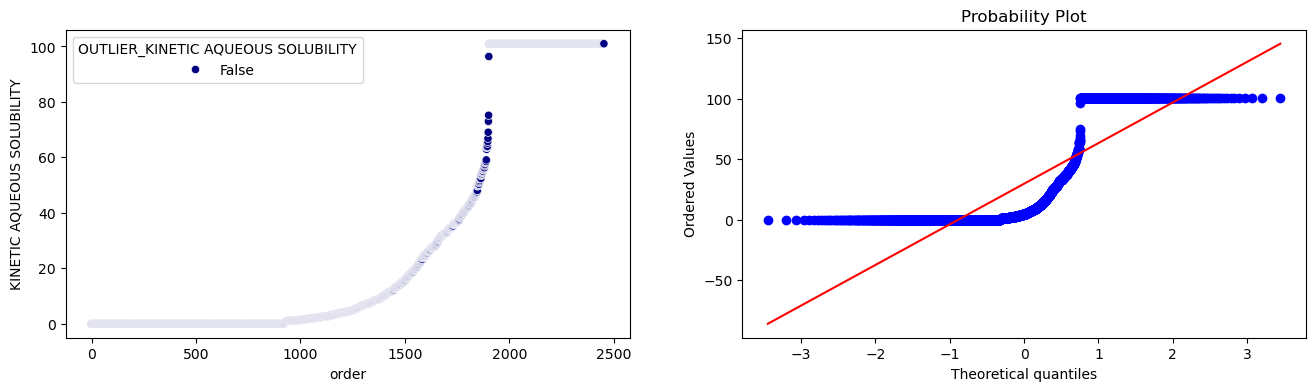

In [13]:
visualize_distribution(dataset=data_look, data_cols=data_cols)

The flagged outliers are likely false outliers as they are located on the end of the data distribution.

### Check activity shift between stereoisomers

In [14]:
data_look[[col for col in data_look.columns if "stereo_cliff" in col]].sum()

PUBCHEM_ACTIVITY_OUTCOME_stereo_cliff      0
PUBCHEM_ACTIVITY_SCORE_stereo_cliff        0
PHENOTYPE_stereo_cliff                     0
KINETIC AQUEOUS SOLUBILITY_stereo_cliff    0
dtype: object

No activity shifts were detected in the dataset.

### Check the molecules with undefined stereocenters

Note: feature currently not working

In [15]:
# data_look['mol'] = data_look['smiles'].apply(dm.to_mol) # Convert smiles to RDKit Mol object
# fig, _ = check_undefined_stereocenters(dataset=data_look)
# fig

In [16]:
# _[data_cols].boxplot(rot=90)

### Re-run curation, removing molecules as needed

In [17]:
### Re-run the curation steps, this time removing molecules with undefined stereoisomers and removing duplicates
curator_with_stereo = curation.MolecularCurator(
    data=data,
    data_cols=data_cols,
    mol_col=mol_col,
    # remove molecules which has undefined stereocenter and also show activity shift to the sterepisomers
    mask_stereo_undefined_mols=True,
    # remove all the molecule rows including the duplicates
    keep_all_rows=False,
)
data_curated = curator_with_stereo()

2024-03-28 16:12:19.692 | WARNING  | polaris.curation._data_curator:check_outliers:188 - Detected 17 outliers for data column PUBCHEM_ACTIVITY_SCORE using zscore. Please revise the data and consider remove the outliers. 
/Users/shawn.whitfield/Documents/ValenceLabs/Polaris/polaris/polaris/curation/utils.py:183: RuntimeWarning: divide by zero encountered in divide
  mod_zscore = deviation_from_med / (consistency_correction * mad)
/Users/shawn.whitfield/Documents/ValenceLabs/Polaris/polaris/polaris/curation/utils.py:183: RuntimeWarning: invalid value encountered in divide
  mod_zscore = deviation_from_med / (consistency_correction * mad)
/Users/shawn.whitfield/Documents/ValenceLabs/Polaris/polaris/polaris/curation/_data_curator.py:77: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.loc[data[NO_STEREO_UNIQUE_ID].isin(mo

In [18]:
print(data.shape)
print(data_curated.shape)
data_curated

(2456, 5)
(2454, 32)


,SMILES,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_ACTIVITY_SCORE,PHENOTYPE,KINETIC AQUEOUS SOLUBILITY,ORIGINAL_PUBCHEM_ACTIVITY_OUTCOME,ORIGINAL_PUBCHEM_ACTIVITY_SCORE,ORIGINAL_PHENOTYPE,ORIGINAL_KINETIC AQUEOUS SOLUBILITY,ORIGINAL_SMILES,...,OUTLIER_PHENOTYPE,OUTLIER_KINETIC AQUEOUS SOLUBILITY,PUBCHEM_ACTIVITY_OUTCOME_zscore,PUBCHEM_ACTIVITY_OUTCOME_stereo_cliff,PUBCHEM_ACTIVITY_SCORE_zscore,PUBCHEM_ACTIVITY_SCORE_stereo_cliff,PHENOTYPE_zscore,PHENOTYPE_stereo_cliff,KINETIC AQUEOUS SOLUBILITY_zscore,KINETIC AQUEOUS SOLUBILITY_stereo_cliff
0,COC1=CC2=C(C=CN=C2C=C1OC)OC3=CC=C(C=C3)NC(=O)C...,0.0,1.0,0.0,0.000,0.0,1.0,0.0,0.000,COC1=CC2=C(C=CN=C2C=C1OC)OC3=CC=C(C=C3)NC(=O)C...,...,False,False,NaN,NaN,-0.674491,NaN,NaN,NaN,-0.674491,NaN
1,C1CN(CCC1C(=O)N)C2=NC(=CS2)C3=CC(=CC=C3)Br,1.0,20.0,1.0,20.470,1.0,20.0,1.0,20.470,C1CN(CCC1C(=O)N)C2=NC(=CS2)C3=CC(=CC=C3)Br,...,False,False,inf,NaN,3.597284,NaN,inf,NaN,2.476314,NaN
2,CC1=CC=CC=C1NC(=O)NC2=CC=CS2,1.0,34.0,1.0,101.000,1.0,34.0,1.0,101.000,CC1=CC=CC=C1NC(=O)NC2=CC=CS2,...,False,False,inf,NaN,6.744908,NaN,inf,NaN,14.871736,NaN
3,C[C@H](/C=C(\C)/C=C/C(=O)NO)C(=O)C1=CC=C(C=C1)...,1.0,45.0,1.0,101.000,1.0,45.0,1.0,101.000,C[C@H](/C=C(\C)/C=C/C(=O)NO)C(=O)C1=CC=C(C=C1)...,...,False,False,inf,NaN,9.218040,NaN,inf,NaN,14.871736,NaN
4,CCN(CC)C(=O)C1=C(C2=C(S1)N(C(=O)N(C2=O)CC3=CC=...,0.0,1.0,0.0,0.000,0.0,1.0,0.0,0.000,CCN(CC)C(=O)C1=C(C2=C(S1)N(C(=O)N(C2=O)CC3=CC=...,...,False,False,NaN,NaN,-0.674491,NaN,NaN,NaN,-0.674491,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2449,CCCC1=NC2=C(C=CC(=C2)C(=O)NC3CCCCC3)SC4=C1C=C(...,0.0,1.0,0.0,1.368,0.0,1.0,0.0,1.368,CCCC1=NC2=C(C=CC(=C2)C(=O)NC3CCCCC3)SC4=C1C=C(...,...,False,False,NaN,NaN,-0.674491,NaN,NaN,NaN,-0.463924,NaN
2450,CC1=C(C=C(C=C1)NC(=O)N(CC2=CN(C3=CC=CC=C32)C)C...,0.0,2.0,0.0,2.367,0.0,2.0,0.0,2.367,CC1=C(C=C(C=C1)NC(=O)N(CC2=CN(C3=CC=CC=C32)C)C...,...,False,False,NaN,NaN,-0.449661,NaN,NaN,NaN,-0.310155,NaN
2451,CCOC(=O)C1=CC=C(C=C1)N2C(=CC(=C2C)C3=NN=C4N3CC...,1.0,56.0,1.0,101.000,1.0,56.0,1.0,101.000,CCOC(=O)C1=CC=C(C=C1)N2C(=CC(=C2C)C3=NN=C4N3CC...,...,False,False,inf,NaN,11.691173,NaN,inf,NaN,14.871736,NaN
2452,C1=CC=C2C(=C1)C(=NC(=N2)C3=CC=NC=C3)NC4=CC=CC=...,0.0,1.0,0.0,0.000,0.0,1.0,0.0,0.000,C1=CC=C2C(=C1)C(=NC(=N2)C3=CC=NC=C3)NC4=CC=CC=...,...,False,False,NaN,NaN,-0.674491,NaN,NaN,NaN,-0.674491,NaN


The curation process has removed two samples from the dataset.

In [19]:
# Additional meta-data on the column level
annotations = {
    "smiles": ColumnAnnotation(description="Molecule SMILES string", modality="molecule"),

    'PUBCHEM_ACTIVITY_OUTCOME': ColumnAnnotation(description="Binarized label based on the phenotype observed, active if Moderate/High Solubility (class = 1) or inactive if Low Solubility (class = 0).",
                                user_attributes={"ref_col": 'PHENOTYPE'}),

    'PUBCHEM_ACTIVITY_SCORE': ColumnAnnotation(description="Whole number in solubility (ug/mL) of the compound.",
                                user_attributes={"ref_col": 'KINETIC AQUEOUS SOLUBILITY',
                                                 "unit": "ug/mL"}),

    'PHENOTYPE': ColumnAnnotation(description='Indicates type of activity observed: 0-10: Low Solubility (Class = 0); >10: Moderate/High Solubility (Class = 1)',
                                user_attributes={"ref_col": 'KINETIC AQUEOUS SOLUBILITY'}),

    'KINETIC AQUEOUS SOLUBILITY': ColumnAnnotation(description= 'Numerical value of the observed aqueous solubility.',
            user_attributes={"unit": "ug/mL"}),
}

In [20]:
dataset = Dataset(
    # The table is the core data-structure required to construct a dataset
    table=data_curated,
    # Additional meta-data on the dataset level.
    name="ADME_NCATS_Solubility",
    description="ADME Solubility experiment data released by the National Center for Advancing Translational Sciences",
    source="https://doi.org/10.1016/j.bmc.2019.05.037",
    annotations=annotations,
    tags=["ADME"],
    owner=HubOwner(user_id="Shawn Whitfield", slug="swhitfield"),
    license=License(id="MIT"),
    user_attributes={"year": "2021"},
)

In [21]:
# Make a temporary directory to save the dataset
temp_dir = tempfile.TemporaryDirectory().name

save_dir = dm.fs.join(temp_dir, "dataset")

path = dataset.to_json(save_dir)

# Look at the save destination
fs = dm.fs.get_mapper(save_dir).fs
fs.ls(save_dir)

/Users/shawn.whitfield/miniconda3/envs/polaris_datasets/lib/python3.12/site-packages/pydantic/main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `url` but got `str` - serialized value may not be as expected
  Expected `url` but got `str` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


['/var/folders/kq/q3sv3jmd5ys443j8rfrgmrxm0000gq/T/tmpscm77f8o/dataset/table.parquet',
 '/var/folders/kq/q3sv3jmd5ys443j8rfrgmrxm0000gq/T/tmpscm77f8o/dataset/dataset.json']

In [23]:
# data_curated.to_parquet(f'./data/{aid}_curated.parquet') # Save just in case. Requires a data folder.

In [24]:
# Load dataset through json file given
# dataset = load_dataset(path)

In [25]:


# NOTE: Commented out to not flood the DB
# with PolarisHubClient() as client:
#     client.upload_dataset(dataset=dataset)